In [1]:
import sys
sys.path.append('../../../')

In [2]:
from win10toast import ToastNotifier
toast = ToastNotifier()

In [3]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train_reg import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

Using backend: pytorch


In [4]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [5]:
do_train = True

seed = 4444
set_seed(seed)

metric_filter_1 = 'test_mcc'
metric_filter_2 = 'val_mcc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [6]:
sets_lengths = (0.5, 0.25, 0.25)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = 1

## Baseline

### FNN

In [7]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [15] * 2, [15] * 3],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [8]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=False,
            loss_type='mse',
        )

100%|██████████| 30/30 [02:27<00:00,  4.91s/it]


#### Results

In [9]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 330/330 [00:15<00:00, 21.01it/s]


In [10]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [5, 10, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.6142807,
 'train_acc': 0.5026666522026062,
 'val_acc': 0.5253333449363708,
 'epoch': 80,
 'model_class': 'fnn',
 'path_name': '4_[5_10_15]_4_ReLU()_bn_0.0_0.1_adamw_max_val_mcc_False_mse_False_0_80',
 'train_rmse': 0.9633275663033837,
 'val_rmse': 0.92951600308978,
 'test_rmse': 1.0276186062932104,
 'train_rmse_perc': 0.23391087,
 'val_rmse_perc': 0.217079,
 'test_rmse_perc': 0.23945078,
 'train_mcc': 0.35632903739468524,
 'val_mcc': 0.39375483883472195,
 'test_mcc': 0.3459756574096878,
 'test_acc': 0.4986666738986969}

In [11]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.72404575,
 'train_acc': 0.48399999737739563,
 'val_acc': 0.4586666524410248,
 'epoch': 30,
 'model_class': 'fnn',
 'path_name': '4_[5_10_15]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_False_mse_False_0_30',
 'train_rmse': 0.8988882021697693,
 'val_rmse': 0.9018499505645788,
 'test_rmse': 0.9309493362512627,
 'train_rmse_perc': 0.23572184,
 'val_rmse_perc': 0.22673085,
 'test_rmse_perc': 0.23733217,
 'train_mcc': 0.33997024478011884,
 'val_mcc': 0.30854157885667927,
 'test_mcc': 0.35778403774236234,
 'test_acc': 0.4906666576862335}

In [12]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': None,
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.61686045,
 'train_acc': 0.4973333477973938,
 'val_acc': 0.5546666383743286,
 'epoch': 60,
 'model_class': 'fnn',
 'path_name': '4_[10_15_20]_4_ReLU()_None_0.0_0.1_adamw_max_val_mcc_False_mse_False_0_60',
 'train_rmse': 0.8500980335624043,
 'val_rmse': 0.7933053216343209,
 'test_rmse': 0.9062744249582095,
 'train_rmse_perc': 0.20417824,
 'val_rmse_perc': 0.18510053,
 'test_rmse_perc': 0.21072838,
 'train_mcc': 0.341798502998011,
 'val_mcc': 0.43123331297597095,
 'test_mcc': 0.30006046218876326,
 'test_acc': 0.46399998664855957}

In [13]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 330/330 [00:00<00:00, 30081.07it/s]


### GCN

In [14]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [15]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 72/72 [09:44<00:00,  8.12s/it]


#### Results

In [16]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 792/792 [00:52<00:00, 15.05it/s]


In [17]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.68333554,
 'train_acc': 0.41866666078567505,
 'val_acc': 0.4399999976158142,
 'epoch': 92,
 'model_class': 'gcn',
 'path_name': '4_[10_15_20]_4_ReLU()_none_bn_0.0_0.1_adamw_max_val_mcc_True_mse_True_0',
 'train_rmse': 0.9018499505645788,
 'val_rmse': 0.8809086218218096,
 'test_rmse': 0.8610071621846901,
 'train_rmse_perc': 0.21872705,
 'val_rmse_perc': 0.2133373,
 'test_rmse_perc': 0.20638525,
 'train_mcc': 0.3189117096690555,
 'val_mcc': 0.34163409615647156,
 'test_mcc': 0.36677882833176745,
 'test_acc': 0.4506666660308838}

In [18]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.68333554,
 'train_acc': 0.41866666078567505,
 'val_acc': 0.4399999976158142,
 'epoch': 92,
 'model_class': 'gcn',
 'path_name': '4_[10_15_20]_4_ReLU()_none_bn_0.0_0.1_adamw_max_val_mcc_True_mse_True_0',
 'train_rmse': 0.9018499505645788,
 'val_rmse': 0.8809086218218096,
 'test_rmse': 0.8610071621846901,
 'train_rmse_perc': 0.21872705,
 'val_rmse_perc': 0.2133373,
 'test_rmse_perc': 0.20638525,
 'train_mcc': 0.3189117096690555,
 'val_mcc': 0.34163409615647156,
 'test_mcc': 0.36677882833176745,
 'test_acc': 0.4506666660308838}

In [19]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.7284011,
 'train_acc': 0.41733333468437195,
 'val_acc': 0.445333331823349,
 'epoch': 50,
 'model_class': 'gcn',
 'path_name': '4_[15_15_15]_4_ReLU()_none_bn_0.2_0.1_adamw_max_val_mcc_True_mse_True_0_50',
 'train_rmse': 0.9070097390142328,
 'val_rmse': 0.886942313043338,
 'test_rmse': 0.867179335547152,
 'train_rmse_perc': 0.21937785,
 'val_rmse_perc': 0.21130742,
 'test_rmse_perc': 0.20647003,
 'train_mcc': 0.32000731566606294,
 'val_mcc': 0.35496564764270006,
 'test_mcc': 0.3538091767522614,
 'test_acc': 0.4399999976158142}

In [20]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 792/792 [00:00<00:00, 27383.47it/s]


### GraphSAGE

In [21]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [22]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 144/144 [3:48:17<00:00, 95.12s/it]  


#### Results

In [23]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

toast.show_toast("Done")

100%|██████████| 1188/1188 [08:54<00:00,  2.22it/s]


True

In [24]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [20, 20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.043677393,
 'train_acc': 0.8640000224113464,
 'val_acc': 0.8880000114440918,
 'epoch': 99,
 'model_class': 'sage',
 'path_name': '4_[20_20_20]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_True_0',
 'train_rmse': 0.41633319989322654,
 'val_rmse': 0.3346640106136302,
 'test_rmse': 0.38297084310253526,
 'train_rmse_perc': 0.10342056,
 'val_rmse_perc': 0.09345121,
 'test_rmse_perc': 0.09918188,
 'train_mcc': 0.8239426488750589,
 'val_mcc': 0.8551504298605307,
 'test_mcc': 0.8493494490180827,
 'test_acc': 0.8853333592414856}

In [25]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.043677393,
 'train_acc': 0.8640000224113464,
 'val_acc': 0.8880000114440918,
 'epoch': 99,
 'model_class': 'sage',
 'path_name': '4_[20_20_20]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_True_0',
 'train_rmse': 0.41633319989322654,
 'val_rmse': 0.3346640106136302,
 'test_rmse': 0.38297084310253526,
 'train_rmse_perc': 0.10342056,
 'val_rmse_perc': 0.09345121,
 'test_rmse_perc': 0.09918188,
 'train_mcc': 0.8239426488750589,
 'val_mcc': 0.8551504298605307,
 'test_mcc': 0.8493494490180827,
 'test_acc': 0.8853333592414856}

In [26]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 25, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.04982726,
 'train_acc': 0.8479999899864197,
 'val_acc': 0.8960000276565552,
 'epoch': 100,
 'model_class': 'sage',
 'path_name': '4_[20_25_20]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_True_0_100',
 'train_rmse': 0.4226897995772629,
 'val_rmse': 0.3346640106136302,
 'test_rmse': 0.3723797345005051,
 'train_rmse_perc': 0.10362234,
 'val_rmse_perc': 0.09466439,
 'test_rmse_perc': 0.096566826,
 'train_mcc': 0.8035676976725092,
 'val_mcc': 0.8642071315306163,
 'test_mcc': 0.829518626873354,
 'test_acc': 0.8693333268165588}

In [27]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1188/1188 [00:00<00:00, 27701.95it/s]


#### cm

In [28]:
cm = all[sort_idx[0]]['test_cm'][0]

In [29]:
(cm.labels==0).sum()

tensor(106)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

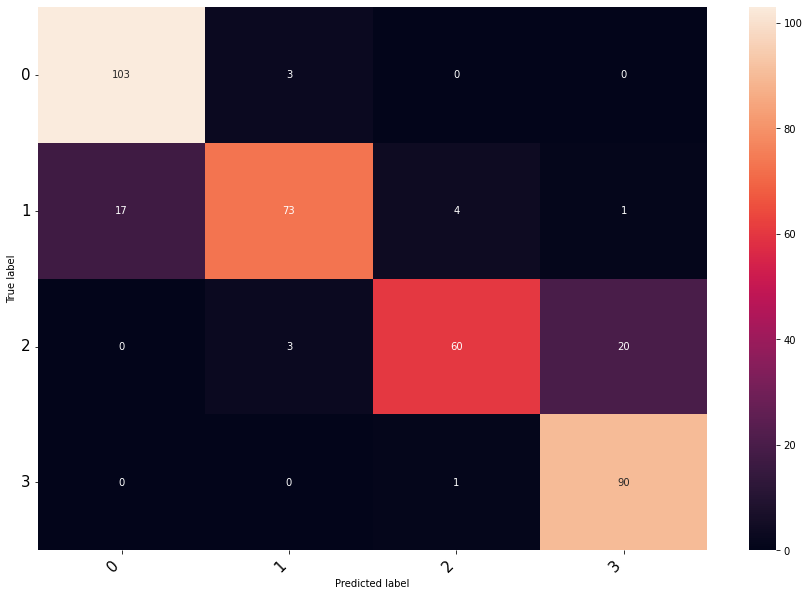

In [30]:
cm.visualize()

In [31]:
cm.class_accuracy

tensor([0.9717, 0.7684, 0.7229, 0.9890])

In [32]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.08615878, 0.10359338, 0.10501849, 0.092294335]

In [33]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.07153241, 0.07377991, 0.07571145, 0.07650742]

#### GraphSAGE Base_n

In [34]:
save_model = f'{save_path}_sage_base'
log_dir = f'{log_path}_sage_base'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [35]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            base_n=True,
        )

100%|██████████| 144/144 [3:32:20<00:00, 88.48s/it]  


##### Results

In [36]:
res_edges_sage_base = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    base_n=True,
)

toast.show_toast("Done")

100%|██████████| 1188/1188 [06:26<00:00,  3.08it/s]


True

In [37]:
res_edges = res_edges_sage_base
res_edges[0]

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.100504436,
 'train_acc': 0.6706666946411133,
 'val_acc': 0.7013333439826965,
 'epoch': 40,
 'model_class': 'sage',
 'path_name': '4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_True_0_40',
 'train_rmse': 0.6131883886702356,
 'val_rmse': 0.6175219294351686,
 'test_rmse': 0.5465040408511787,
 'train_rmse_perc': 0.12540326,
 'val_rmse_perc': 0.13587227,
 'test_rmse_perc': 0.118083954,
 'train_mcc': 0.5721119308275434,
 'val_mcc': 0.6133208366535009,
 'test_mcc': 0.6598583578472232,
 'test_acc': 0.7333333492279053}

In [38]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.100504436,
 'train_acc': 0.6706666946411133,
 'val_acc': 0.7013333439826965,
 'epoch': 40,
 'model_class': 'sage',
 'path_name': '4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_True_0_40',
 'train_rmse': 0.6131883886702356,
 'val_rmse': 0.6175219294351686,
 'test_rmse': 0.5465040408511787,
 'train_rmse_perc': 0.12540326,
 'val_rmse_perc': 0.13587227,
 'test_rmse_perc': 0.118083954,
 'train_mcc': 0.5721119308275434,
 'val_mcc': 0.6133208366535009,
 'test_mcc': 0.6598583578472232,
 'test_acc': 0.7333333492279053}

In [39]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.05885603,
 'train_acc': 0.7106666564941406,
 'val_acc': 0.7226666808128357,
 'epoch': 60,
 'model_class': 'sage',
 'path_name': '4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_True_0_60',
 'train_rmse': 0.5585696017507576,
 'val_rmse': 0.565685424949238,
 'test_rmse': 0.5316640543300503,
 'train_rmse_perc': 0.11765792,
 'val_rmse_perc': 0.1349946,
 'test_rmse_perc': 0.112720095,
 'train_mcc': 0.6193906542418169,
 'val_mcc': 0.6435221478052081,
 'test_mcc': 0.642233667153797,
 'test_acc': 0.7253333330154419}

In [40]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1188/1188 [00:00<00:00, 29779.90it/s]


##### cm

In [41]:
cm = all[sort_idx[0]]['test_cm'][0]

In [42]:
(cm.labels==0).sum()

tensor(92)

In [43]:
cm.pseudo_perc.max()

tensor(0.9999)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

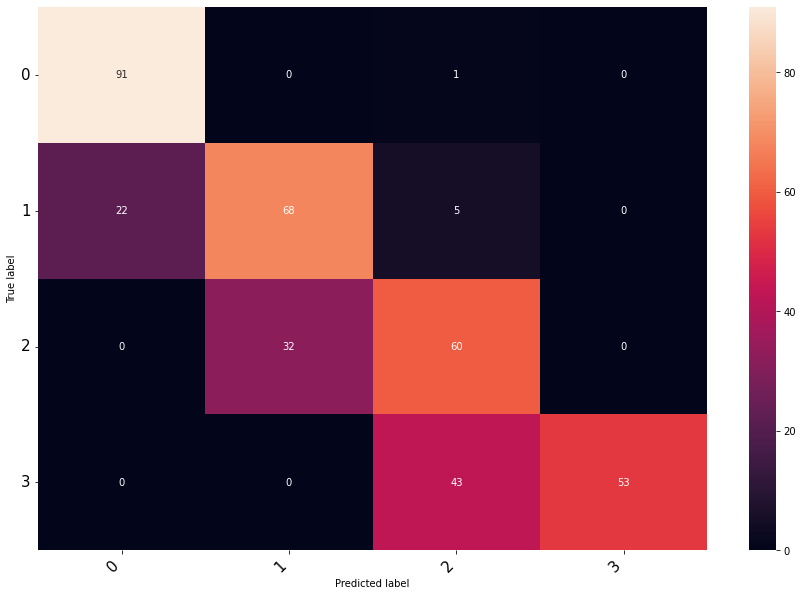

In [44]:
cm.visualize()

In [45]:
cm.class_accuracy

tensor([0.9891, 0.7158, 0.6522, 0.5521])

In [46]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.092889406, 0.10761811, 0.09886002, 0.14330418]

In [47]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.07652956, 0.09376391, 0.087468415, 0.12798524]

### GAT

In [48]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    use_edge_weight=[False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [49]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 288/288 [30:22<00:00,  6.33s/it]


#### Results

In [50]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 3168/3168 [02:28<00:00, 21.26it/s]


In [51]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [25],
 'out_features': 1,
 'num_heads': [4, 4],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.66258526,
 'train_acc': 0.6306666731834412,
 'val_acc': 0.6159999966621399,
 'epoch': 95,
 'model_class': 'gat',
 'path_name': '4_[25]_1_[4_4]_bn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_True_0.2',
 'train_rmse': 0.7211102550927979,
 'val_rmse': 0.7554248252914824,
 'test_rmse': 0.6713171133426189,
 'train_rmse_perc': 0.16239554,
 'val_rmse_perc': 0.18281142,
 'test_rmse_perc': 0.15922773,
 'train_mcc': 0.5102711942016718,
 'val_mcc': 0.4897305634722606,
 'test_mcc': 0.5468098959449775,
 'test_acc': 0.653333306312561}

In [52]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25],
 'out_features': 1,
 'num_heads': [4, 4],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.66258526,
 'train_acc': 0.6306666731834412,
 'val_acc': 0.6159999966621399,
 'epoch': 95,
 'model_class': 'gat',
 'path_name': '4_[25]_1_[4_4]_bn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_True_0.2',
 'train_rmse': 0.7211102550927979,
 'val_rmse': 0.7554248252914824,
 'test_rmse': 0.6713171133426189,
 'train_rmse_perc': 0.16239554,
 'val_rmse_perc': 0.18281142,
 'test_rmse_perc': 0.15922773,
 'train_mcc': 0.5102711942016718,
 'val_mcc': 0.4897305634722606,
 'test_mcc': 0.5468098959449775,
 'test_acc': 0.653333306312561}

In [53]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25],
 'out_features': 1,
 'num_heads': [4, 4],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.66258526,
 'train_acc': 0.6306666731834412,
 'val_acc': 0.6159999966621399,
 'epoch': 95,
 'model_class': 'gat',
 'path_name': '4_[25]_1_[4_4]_bn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_True_0.2',
 'train_rmse': 0.7211102550927979,
 'val_rmse': 0.7554248252914824,
 'test_rmse': 0.6713171133426189,
 'train_rmse_perc': 0.16239554,
 'val_rmse_perc': 0.18281142,
 'test_rmse_perc': 0.15922773,
 'train_mcc': 0.5102711942016718,
 'val_mcc': 0.4897305634722606,
 'test_mcc': 0.5468098959449775,
 'test_acc': 0.653333306312561}

In [54]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 3168/3168 [00:00<00:00, 29686.96it/s]
